In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [5]:
import numpy as np
import PIL.Image as Image
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
    

In [6]:
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)

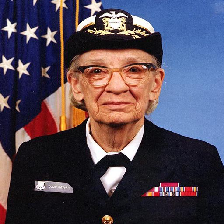

In [7]:
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0

In [9]:
grace_hopper.shape

(224, 224, 3)

In [10]:
result = classifier.predict(grace_hopper[np.newaxis,...])

In [11]:
result.shape


(1, 1001)

In [12]:
predicted_class = np.argmax(result[0],axis=-1)
predicted_class

653

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [14]:
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [15]:
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

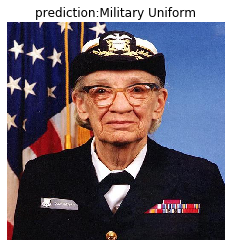

In [16]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("prediction:"+predicted_class_name.title())

In [17]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [18]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
image_data = image_generator.flow_from_directory(str(data_root),target_size = IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [19]:
image_data.num_classes

5

In [20]:
for image_batch,label_batch in image_data:
    print("Image batch shape:",image_batch.shape)
    print("label batch shape",label_batch.shape)
    break

Image batch shape: (32, 224, 224, 3)
label batch shape (32, 5)


In [21]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [22]:
predicted_class_names = imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_names

array(['daisy', 'lakeside', 'bee', 'rapeseed', 'daisy', 'daisy', 'daisy',
       'bee', 'stinkhorn', 'hip', 'brain coral', 'daisy', 'rapeseed',
       'bee', 'strawberry', 'Bedlington terrier', 'daisy', 'daisy',
       'quill', 'picket fence', 'daisy', 'daisy', 'mushroom', 'daisy',
       'daisy', 'vase', 'cardoon', 'fly', 'rapeseed', 'earthstar',
       'picket fence', 'pinwheel'], dtype='<U30')

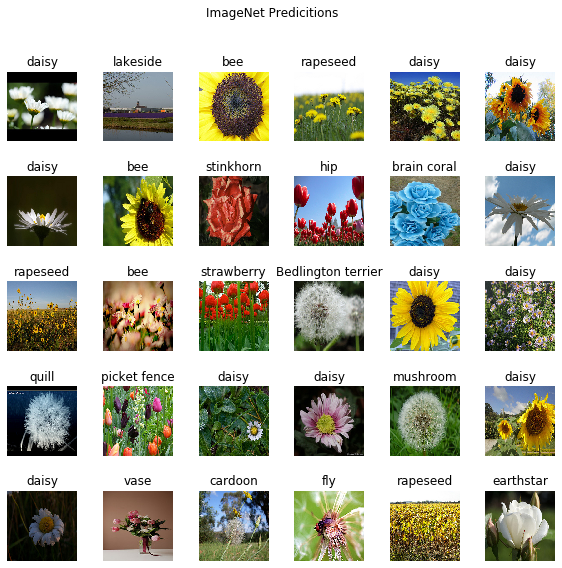

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace = 0.5)
for n in range(30):
    plt.subplot(5,6,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_=plt.suptitle("ImageNet Predicitions")

In [24]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [25]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [26]:
feature_batch = feature_extractor_layer(image_batch)

In [27]:
print(feature_batch.shape)

(32, 1280)


In [28]:
feature_extractor_layer.trainable=False

In [29]:
image_data.num_classes

5

In [30]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
predictions = model(image_batch)

In [32]:
predictions.shape

TensorShape([32, 5])

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['acc'])

In [34]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    def on_train_batch_end(self,batch,logs = None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [35]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 430s 4s/step - loss: 0.6701 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 424s 4s/step - loss: 0.3375 - acc: 0.8125


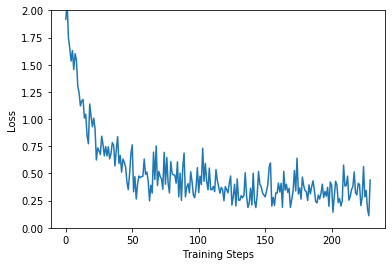

In [36]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

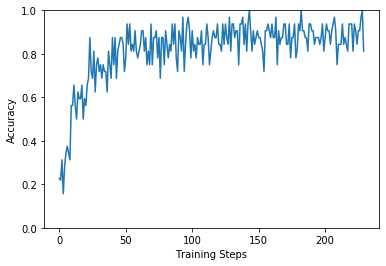

In [37]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [38]:
class_names = sorted(image_data.class_indices.items(),key = lambda pair:pair[1])
class_names = np.array([key.title() for key , value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [39]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch,axis=-1)
predicted_label_batch = class_names[predicted_id]

In [40]:
label_id = np.argmax(label_batch, axis=-1)

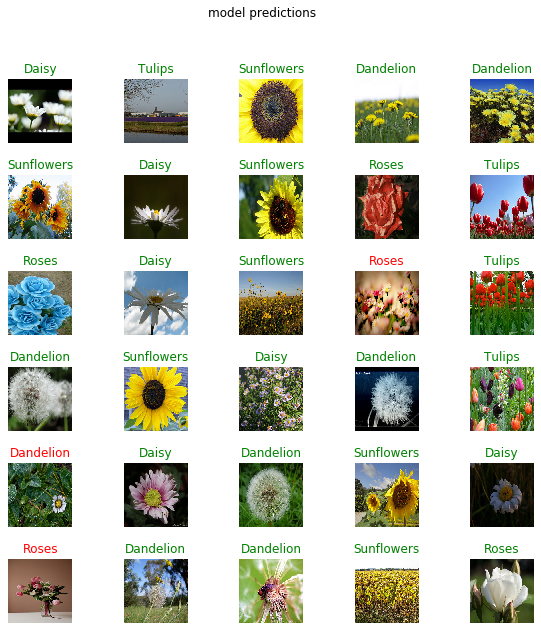

In [48]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(),color = color)
    plt.axis('off')
_ = plt.suptitle("model predictions")

In [53]:
#import time
#t=time.time()
#export_path ="/tmp/saved_models/{}".format(int(t))
import os
pathh = os.getcwd()
model.save(filepath = pathh,save_format='tf')

#export_path

INFO:tensorflow:Assets written to: C:\Users\Sujay J\Desktop\TensorFlow\mobilenetV2\assets


INFO:tensorflow:Assets written to: C:\Users\Sujay J\Desktop\TensorFlow\mobilenetV2\assets


In [54]:
reload = tf.keras.models.load_model(pathh)

In [56]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reload.predict(image_batch)

In [57]:
abs(reloaded_result_batch-result_batch).max()

0.0